# TRANSFER LEARNING (VGG19 CNN)

Aside from related clinical data, Open Access Series of Imaging Studies (OASIS) brain dataset also contains **MRI Brain Images**.

Since alzheimer's disease diagnosis also relies on neuroimaging techniques, we decided to implement **Convolution Neural Network (CNN)** for (MRI)image recognition and applied **Transfer Learning** on pre-trained **Visual Geometry Group 19 (VGG19) CNN model**.

VGG19 has 19 hidden layers and approximately 143 million parameters. The model has been pre-trained on a large dataset of colored images, typically ImageNet, spanning 1000 different categories. For the task of Alzheimer's recognition using MRI images, we will repurpose this pre-trained model.

# Import Essential Python Libraries

check if the modules are installed in your environment!

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
import os
import random
import re
from collections import defaultdict

In [2]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
# Import essential models and functions from tensorflow
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2024-04-18 23:26:20.279724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the Cleaned Dataset

In [4]:
# Load the cleaned dataset containing demographic information and MRI IDs
alzheimersData = pd.read_csv('cleaned-alzheimers-dataset.csv')

# Display the cleaned dataset
alzheimersData

,Unnamed: 0,MRI ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...,...
603,603,OAS2_0185_MR2,M,82,1.0,1.0,28.0,0.5,1693,0.694,1.037
604,604,OAS2_0185_MR3,M,86,1.0,1.0,26.0,0.5,1688,0.675,1.040
605,605,OAS2_0186_MR1,F,61,1.0,2.0,30.0,0.0,1319,0.801,1.331
606,606,OAS2_0186_MR2,F,63,1.0,2.0,30.0,0.0,1327,0.796,1.323


Our group decided to use the corresponding brain MRI images from **OASIS Alzheimer's Detection Kaggle Dataset** (https://www.kaggle.com/datasets/ninadaithal/imagesoasis/data).

Since the brain MRI images only belong to `OAS1`, we will drop the values that belong to `OAS2` under `MRI ID`.

In [5]:
alzheimersData_OAS1 = alzheimersData[~alzheimersData['MRI ID'].str.contains('OAS2')]

alzheimersData_OAS1

,Unnamed: 0,MRI ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...,...
230,230,OAS1_0453_MR1,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355
231,231,OAS1_0454_MR1,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
232,232,OAS1_0455_MR1,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
233,233,OAS1_0456_MR1,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


# Exploring MRI Image Data

**OASIS Alzheimer's Detection Kaggle Dataset** contains **80,000 MRI slice images of four classes** according to the subject's Alzheimer's Disease diagnosis and the stage of dementia:

- Non Demented
- Very mild Dementia
- Mild Dementia
- Moderate Dementia

Image example: Mild Dementia


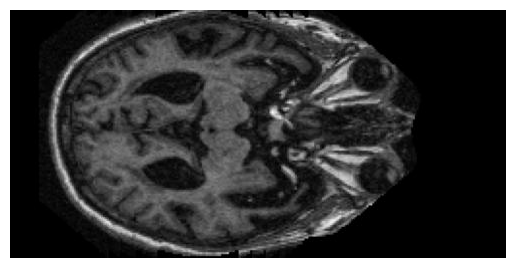

Image dimensions: (248, 496)
Number of channels: 3
Number of samples by class:
- Mild Dementia: 5002
- Moderate Dementia: 488
- Non Demented: 67222
- Very Mild Dementia: 13725


In [6]:
# Set the directory where brain MRI Images are located
data_dir = 'OAS1_MRI'

# Get the list of labels (subfolders), excluding hidden files
labels = [label for label in os.listdir(data_dir) if not label.startswith('.')]

# Choose a random label and a random image within that label
random_label = np.random.choice(labels)
random_img = np.random.choice(os.listdir(os.path.join(data_dir, random_label)))
img_path = os.path.join(data_dir, random_label, random_img)

# Load the image
img = plt.imread(img_path)

# Display the image
print("Image example:", random_label)
plt.imshow(img)
plt.axis('off')
plt.show()

# Image information
print("Image dimensions:", img.shape[0:2])
print("Number of channels:", img.shape[2])

# Number of samples
print("Number of samples by class:")
for label in sorted(labels):
    print(f"- {label}: {len(os.listdir(os.path.join(data_dir, label)))}")

JPEG compression reduces the file size of images while preserving visual quality, making it efficient for storing and transferring large amounts of image data. This can be advantageous when dealing with large datasets in CNN training pipelines. However,  JPEG compression is lossy, meaning that some image information is discarded during compression, leading to a reduction in image quality. This loss of information can negatively impact CNN performance, especially for tasks that require fine-grained details or precise pixel-level features.

Given that the existing dataset available is in JPG format, we decided to keep them unchanged. For future improvements, we may choose to use lossless image formats like PNG or TIFF, especially for applications requiring preservation of pixel-level accuracy or fidelity.

# Processing MRI Image Data

There is a *standard naming convention* in the Brain MRI JPG Images: *OAS1_{Patient Index}_{MRI Visit}_{Brain Slice Image Type}_{Image Index}.jpg*

Since the dataset consists of 80,000 brain MRI images, we decided to reduce the number of MRI images to reduce the computational time (in training the model).

Our group decided to randomly select the brain MRI images, ensuring that each patient has at least 1 image from each brain slice type from that particular MRI visit (considering there were multiple visits by some patients). This ensures accuracy and reliability of our CNN model.

In [7]:
# Set the directory where brain MRI Images are located
data_dir = 'OAS1_MRI'

# Get the list of labels (subfolders), excluding hidden files
labels = [label for label in os.listdir(data_dir) if not label.startswith('.')]

# Function to parse the image filenames and organize them by patient, visit, brain slice type, and subfolder
def parse_filenames(filenames):
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
    for filename in filenames:
        parts = filename.split("_")
        patient_index = parts[2]
        mri_visit = parts[3]
        brain_slice_type = parts[4]
        subfolder = filename.split(os.path.sep)[-2]  # Extract subfolder name from path
        data[patient_index][mri_visit][brain_slice_type][subfolder].append(filename)
    return data

# Function to randomly choose images ensuring each patient has at least one image from each brain slice type in each MRI visit
def choose_images(data, num_images_per_patient):
    chosen_images = []
    chosen_labels = []

    for patient_index, visits in data.items():
        for visit, slices in visits.items():
            for slice_type, subfolders in slices.items():
                for subfolder, filenames in subfolders.items():
                    chosen_filenames = random.sample(filenames, min(num_images_per_patient, len(filenames)))
                    chosen_images.extend(chosen_filenames)
                    chosen_labels.extend([subfolder] * len(chosen_filenames))  # Use subfolder as label

    return chosen_images, chosen_labels

# Get all image filenames
all_filenames = []
for label in labels:
    label_path = os.path.join(data_dir, label)
    all_filenames.extend([os.path.join(label_path, filename) for filename in os.listdir(label_path)])

# Parse filenames and organize by patient, visit, brain slice type, and subfolder
parsed_data = parse_filenames(all_filenames)

# Randomly choose images ensuring each patient has at least one image from each brain slice type in each MRI visit
num_images_per_patient = 1
chosen_images, chosen_labels = choose_images(parsed_data, num_images_per_patient)

# Print the total number of chosen images
total_chosen_images = len(chosen_images)
print("Total number of chosen images:", total_chosen_images)

# Print the chosen images and their labels
for image, label in zip(chosen_images, chosen_labels):
    print(f"Image: {image}, Alzheimer Type: {label}")

Total number of chosen images: 1417
Image: OAS1_MRI/Mild Dementia/OAS1_0137_MR1_mpr-3_124.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0137_MR1_mpr-2_105.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0137_MR1_mpr-4_147.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0137_MR1_mpr-1_101.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0291_MR1_mpr-3_121.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0291_MR1_mpr-2_134.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0291_MR1_mpr-4_148.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0291_MR1_mpr-1_127.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0278_MR1_mpr-2_122.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0278_MR1_mpr-4_148.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0278_MR1_mpr-3_105.jpg, Label: Mild Dementia
Image: OAS1_MRI/Mild Dementia/OAS1_0278_MR1_mpr-1_159.jpg, Label: Mild Dementia
Imag

# CNN Model (VGG19)

### 1) Model Definition

Load the pre-trained VGG19 model without the top layers. The fully connected layers (top layers) of the VGG19 model were designed for a 1000-class image classification task. Hence, Our group replaced these layers with new ones tailored to our task, specifically classifying brain MRI images into the four classes (Non Demented, Mild Dementia, Very Mild Dementia, Moderate Dementia).

In [8]:
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### 2) Freeze the Pre-Trained Layers

By freezing the pre-trained layers, we reduce the risk of overfitting, especially when working with limited amounts of data. By freezing the pre-trained layers, we reduce the number of parameters that need to be trained, leading to faster convergence during training.

In [9]:
# Freeze the pre-trained layers
for layer in vgg19_base.layers:
    layer.trainable = False

### 3) Add Custom Top Layer for Alzheimers Classification

As mentioned, Adding custom top layers allows us to adjust the output layer to match the number of classes in our Alzheimer's classification task (i.e., Non Demented, Mild Dementia, Very Mild Dementia, and Moderate Dementia).

In [10]:
# Add custom top layers for classification
x = Flatten()(vgg19_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels), activation='softmax')(x)

### 4) Create the Model

In [11]:
# Create the model
model = Model(inputs=vgg19_base.input, outputs=output)

### 5) Compile the Model

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# TRAINING THE MODEL

### 1) Data Preparation

In [13]:
# Prepare the data for the chosen images
image_size = (224, 224)
X = []
y = []

for image_path, label in zip(chosen_images, chosen_labels):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    X.append(img_array)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize pixel values
X = X / 255.0

# Convert non-integer labels to integer labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert class labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y = to_categorical(y_encoded, num_classes=num_classes)

### 2) Split the Dataset

For training, validation and testing in the ratio of 7:1.5:1.5

A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters.

The validation dataset is different from the test dataset that is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.

In [14]:
# Train-Validation-Test Split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


### 3) Early Stopping

Early stopping helps prevent overfitting by monitoring the performance of the model on a separate validation dataset during training. If the validation loss starts to increase or the validation accuracy starts to decrease, it indicates that the model is starting to overfit. Hence, early stopping halts the training process before the model's performance on the validation set deteriorates too much, allowing us to optimize the training time by avoiding unnecessary epochs.

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

### 4) Training!

*NOTE*: The model will take a significant amount of time to train! If you wish to improve the time-complexity, consider increasing `batch_size` or decreasing `patience` in `early_stopping` or `epochs`. However, this may affect model performance and accuracy.

You will just need to load the model if the model has been trained before. If you wish to retrain the model, please delete the existing saved model.

In [16]:
model_path = 'vgg19_AlzheimersModel.h5'
if os.path.exists(model_path):
    # Load the saved model
    model = load_model(model_path)
    print("Model loaded successfully.")
else:
    # Train the model
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Save the model in the native Keras format
    model.save('vgg19_AlzheimersModel.h5')
    print("Model saved successfully.")

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 862s 28s/step - accuracy: 0.5947 - loss: 6.5210 - val_accuracy: 0.7840 - val_loss: 0.8287
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 867s 28s/step - accuracy: 0.7155 - loss: 1.0427 - val_accuracy: 0.7700 - val_loss: 0.6291
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 859s 28s/step - accuracy: 0.7660 - loss: 0.6276 - val_accuracy: 0.7793 - val_loss: 0.6134
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 861s 28s/step - accuracy: 0.7887 - loss: 0.5507 - val_accuracy: 0.7746 - val_loss: 0.5928
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 909s 29s/step - accuracy: 0.7499 - loss: 0.5841 - val_accuracy: 0.7746 - val_loss: 0.6715
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 863s 28s/step - accuracy: 0.7833 - loss: 0.6029 - val_accuracy: 0.8122 - val_loss: 0.5952
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 866s 28s/step - accuracy: 0.8095 - loss: 0.5172 - val_accuracy: 0.7840 - val_loss: 0.5713
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 933s 28s/step - accuracy: 0.7983 - loss: 0.5278 - val_accuracy: 0.

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=vgg19_AlzheimersModel.

#  Evaluation and Prediction

### a) Evaluate the Model


In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 151s 21s/step - accuracy: 0.8105 - loss: 0.5732
Test Loss: 0.5076293349266052
Test Accuracy: 0.8309859037399292


**COMMENTS**

*Test loss* is a measure of how well the model is performing on data that it has not seen during training. It is calculated as the error between the predicted outputs of the model and the actual ground truth labels for a set of test data points. A lower test loss indicates better performance, signifing that the model's predictions are closer to the actual values. 

*Test accuracy* is a metric that measures the proportion of correctly classified samples in the test dataset. It is calculated by dividing the number of correctly classified samples by the total number of samples in the test dataset.

In this case, a test accuracy of `83.1%` can be considered to be good, especially given that only 1417 JPG images out of the available 80,000 images were used to train the model.

While a test loss of `0.508` may be considered high, it is important to note that a pre-trained VGG19 layers were freezed to reduce time complexity. This may have hindered the performance in the model in correctly predicting the values.

Image recognition may require more complex models to achieve higher accuracy compared to linear regression. Fundamentally, our CNN model serves as the basic first step in attempting MRI Brain Image recognition.





### b) Visualisation of Accuracy and Validation loss

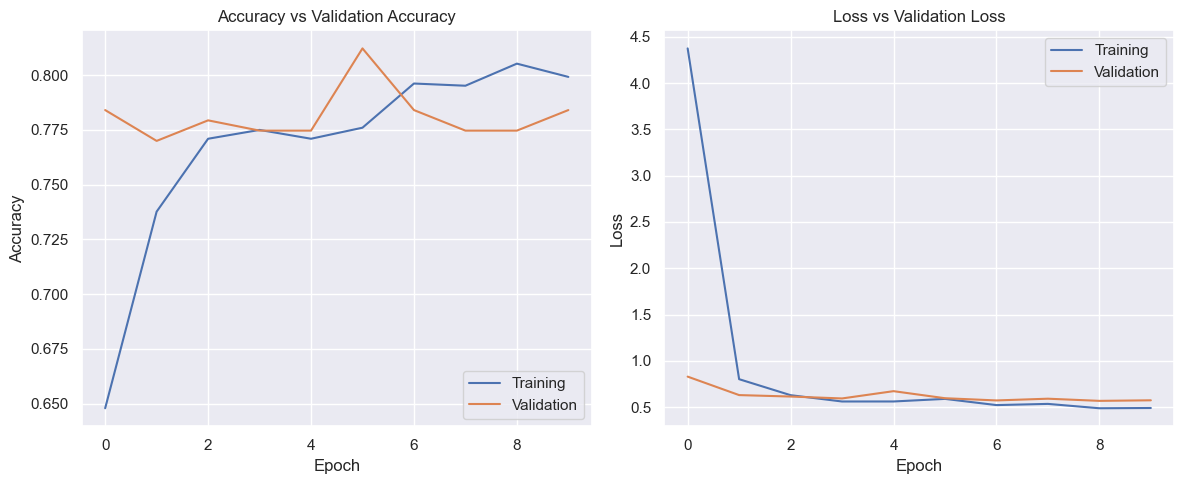

In [19]:
plt.figure(figsize=(12, 5))

# Plot Accuracy vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot Loss vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

**COMMENTS**

In *Accuracy vs Validation Accuracy* graph, comparing the training and validation accuracy trends can help identify whether the model is overfitting or underfitting. If the training accuracy is much higher than the validation accuracy, it indicates overfitting, where the model is memorizing the training data instead of learning general patterns. Conversely, if both training and validation accuracies are low, it suggests underfitting, where the model is too simple to capture the underlying patterns in the data.

In the graph, The model's accuracy generally improves as the number of Epoch increases. However, it can be observed that after Epoch `6`, overfitting is actually occuring and it may be viable for the model to be stopped at that epoch.

Similarly, in *Loss vs Validation Loss* graph, if the training loss is much lower than the validation loss, it indicates overfitting.

In the graph, training loss is lower than validation loss after epoch `6` as well.


### c) Prediction

on 4 random images from the test dataset, linking to the demographic variables in `alzheimersData_OAS1`

7/7 ━━━━━━━━━━━━━━━━━━━━ 223s 32s/step


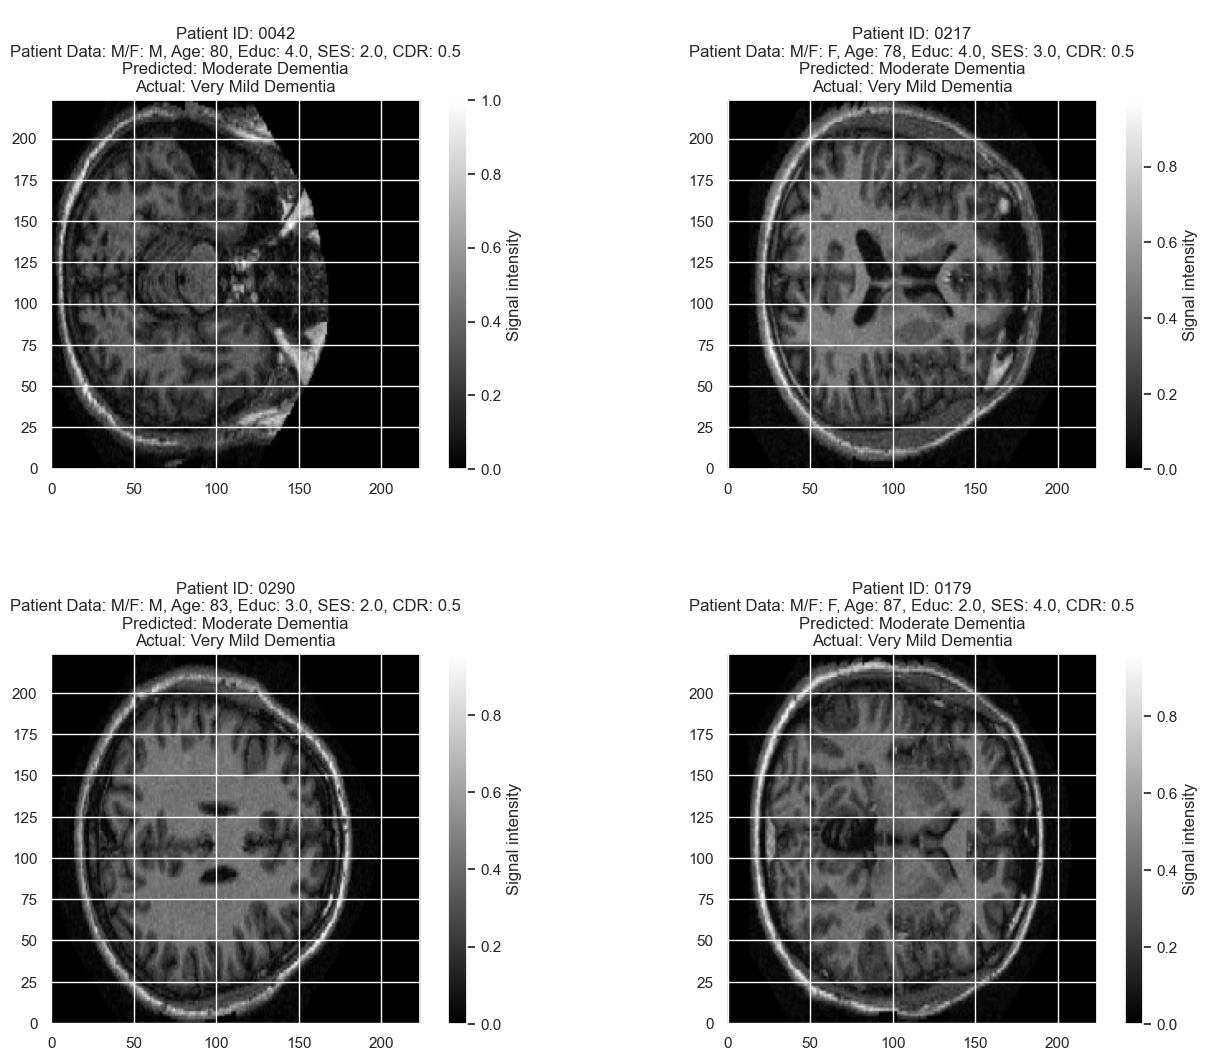

In [25]:
plt.figure(figsize=(16, 12))

# Define the columns you want to display from the patient data
columns_to_display = ['M/F', 'Age', 'Educ', 'SES', 'CDR']

# Get the predicted labels
y_pred = np.argmax(model.predict(X_test), axis=1)

# Choose 4 random images from the test dataset
images = np.random.choice(len(X_test), size=4, replace=False)

for index, image in enumerate(images):
    img_data = X_test[image]

    true = chosen_labels[image]
    actual = labels[y_pred[image]]
    
    # Retrieve the patient index corresponding to the specified image index
    patient_index = patient_ids[image]

    # Check if patient ID exists before retrieving patient data
    if patient_index is not None:
        # Construct the expected patient ID format
        expected_patient_id = f"OAS1_{patient_index}_MR1"
        
        # Retrieve patient data based on the expected ID
        patient_data = alzheimersData_OAS1[alzheimersData_OAS1['MRI ID'] == expected_patient_id]
    else:
        patient_data = None

    # Extract specific information from patient data for display
    if patient_data is not None and not patient_data.empty:
        patient_info_str = ', '.join([f"{column}: {patient_data.iloc[0][column]}" for column in columns_to_display])
    else:
        patient_info_str = "No patient data available"

    plt.subplot(2, 2, index+1)
    plt.title(f'\nPatient ID: {patient_index}\nPatient Data: {patient_info_str}\nPredicted: {actual}\nActual: {true}')
    plt.imshow(img_data[:, :, -1], cmap='gray', origin='lower')
    plt.colorbar(label='Signal intensity')
    plt.subplots_adjust(hspace=0.5)

plt.show()

**COMMENTS**

*Recall*: Clinical Dementia Rating (0 = Normal, 0.5 = Very Mild AD, 1 = Mild, 2 = Moderate, 3 = Severe)

Each of the 4 image used for prediction has their corresponding `Patient ID`, `M/F`, `Age`, `Educ`, `SES`, `CDR` displayed.

The `Actual` corresponds to the relevant `CDR` of each patient, while `Predicted` is the model's predicted classifcation based on the image.

Overall, it is clear that the model is still not accurate in predicting the classification of each image correctly. Again, this is due to a few issues and limitations we encountered such as the time-complexity needed to train the model and the variety of brain slice type images. Most significantly, the training data being fed to the model is *imbalanced* as most of them come from Non-Demented patients. Hence, the model will not be accurate in identifying other types of Alzheimers.

To improve accuracy, some adjustments we can consider is to limit the dataset to a partcular type of brain slice instead of using all types. We may also train the model using a larger image dataset (ensuring that the images from each class of Alzheimers are being fed equally to the model), which is clearly possible given that 80,000 images are available but a little less of 1,500 are used for our training.

In the future, we may even explore the possibility of creating our own custom model which is more suited for MRI greyscale images.

